# Python と Keras によるディープラーニング

- Guthub: https://github.com/fchollet/deep-learning-with-python-notebooks
- 原著： https://livebook.manning.com/#!/book/deep-learning-with-python/about-this-book/

## 6章　テキストとシーケンスのためのディープラーニング

## 6.2 リカレントニューラルネットワーク（RNN）を理解する

- ポイント:
    - 入力と1つ前の出力を結合して現在の出力を取得する
    - Numpy で実装すると、RNN はループの1つ前のイテレーションで計算された数値を再利用する for ループである。
    - よって、出力テンソルの時間刻み t にはそれぞれ、入力シーケンスでの時間刻み0から t に関する情報（過去全体の情報）が含まれている。

In [ ]:
# 擬似コードでの RNN
state_t = 0   # 時間tでの状態
for input_t in input_sequence:  # シーケンスの要素をループ
    output_t = f(input_t, state_t)  # この1つ前の出力が
    state_t = output_t  # 次のイテレーションの状態になる

In [ ]:
# RNN のより詳細な擬似コード
state_t = 0   
for input_t in input_sequence:  
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t  

In [5]:
# 単純な RNN の NumPy の実装
import numpy as np

timesteps = 100        # 入力シーケンスの時間刻みの数
input_features = 32     # 入力特徴空間の次元の数
output_features = 64  # 出力特徴空間の次元の数

# 入力データ：ランダムにノイズを挿入
inputs = np.random.random((timesteps, input_features))

# 初期状態：すべて0のベクトル
state_t = np.zeros((output_features, ))

# ランダムな重み行列を作成
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []

# input_t は形状が (input_features, ) のベクトル
for i, input_t in enumerate(inputs):
    # 入力と現在の状態（1つ前の出力）を結合して現在の出力を取得
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # この出力をリストを格納
    successive_outputs.append(output_t)
    # 次の時間刻みのためにRNNの状態を更新
    state_t = output_t
    
# 最終的な出力は形状が (timesteps, output_features) の2次元テンソル
final_output_sequence = np.stack(successive_outputs, axis=0)

### 6.2.1 Keras でのリカレント層

- RNN のフォワードパスは、 Keras の実際の層、具体的には、 SimpleRNN に相当する。
    - ```from keras.layers import SimpleRNN```
    
- Keras のすべてのリカレント層と同様に、 SimpleRNN も2種類のモードで実行できる。
    - 一方のモードでは、各時間刻みの出力が順番に含まれた完全なシーケンスを返す。
        - 形状が (batch_size, timesteps, output_features) の３次元テンソル
    - もう一方のモードでは、各入力シーケンスの最後の出力だけを返す。
        - 形状が (batch_size, output_features) の2次元テンソル
        
- これら2つのモードは、コンストラクタの return_sequences パラメータによって制御される。

In [7]:
# 最後の時間刻みの出力だけが返される
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

/Users/takayukiishikawa/anaconda/envs/kaggle/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 完全な状態を表すシーケンスが返される
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 場合によっては、複数のリカレント層を順番に積み重ねていくと、ネットワークの表現力を高めるのに役立つことがある。
# このような設定で完全な出力シーケンスを取得するには、中間の層の出力をすべて取得する必要がある。
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 最後の層は最後の出力を返すだけ
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


### 6.2.2 LSTM 層と GRU 層

- SimpleRNN では、実際には、長期間の依存家計を学習することは不可能：　勾配消失問題
    - ネットワークに層を追加し続けていくと、最終的にそのネットワークは訓練不可能となる。
    
- LSTM層：　この層のもとになっているのは長短期記憶（Long Short-Term Memory: LSTM）アルゴリズム

- 

### 6.2.3 Keras での LSTM の具体的な例

### 6.2.4 まとめ

## 6.3 RNN の高度な使い方

- RNNの性能と汎化力を向上させる高度な手法を3つ紹介する
    - リカレントドロップアウト
        - リカレント層でドロップアウトを使って過学習に対抗するための組み込みの手法
    - リカレント層のスタッキング
        - （計算不可が高くなることと引き換えに）ネットワークの表現力を高める手法
    - 双方向のリカレント層
        - 同じ情報を様々な手法で RNN に提供することで、正解率を向上させ、忘却の問題に対処する手法

### 6.3.1 気温予測問題

- ドイツのイエナにある Max Planck Institute for Biogeochemistry の観測所で記録された希少時系列データセットを使用する
    - https://www.bgc-jena.mpg.de/wetter/
    
- このデータセットは、14種類の数値（気温、気圧、湿度、風向など）を10分おきに記録した数年分のデータで構成されている

- このデータセットを使用して、最近のデータ（数日分のデータ点）を入力として受け取り、24時間後の気温の予測するモデルを構築する

In [14]:
# ! mkdir dataset
# ! cd dataset && wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip && unzip jena_climate_2009_2016.csv.zip

mkdir: dataset: File exists
--2018-10-26 14:21:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
s3.amazonaws.com (s3.amazonaws.com) をDNSに問いあわせています... 52.216.161.5
s3.amazonaws.com (s3.amazonaws.com)|52.216.161.5|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 13568290 (13M) [application/zip]
`jena_climate_2009_2016.csv.zip' に保存中

jena_climate_2009_2 100%[===================>]  12.94M  4.25MB/s 時間 3.0s       

2018-10-26 14:21:47 (4.25 MB/s) - `jena_climate_2009_2016.csv.zip' へ保存完了 [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [1]:
import os

data_dir = "dataset"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

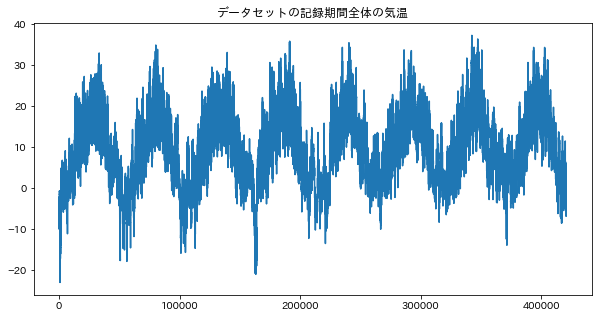

In [3]:
%matplotlib inline
import  matplotlib.pyplot as plt 

temp = float_data[:, 1]  # 気温（摂氏）

plt.figure(figsize=(10,5))
plt.plot(range(len(temp)), temp)
plt.title("データセットの記録期間全体の気温")
plt.show()

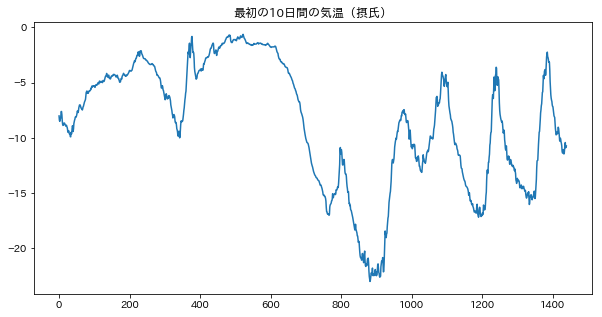

In [4]:
plt.figure(figsize=(10,5))
plt.plot(range(1440), temp[:1440])
plt.title("最初の10日間の気温（摂氏）")
plt.show()

特に最後の4日間については、24時間単位の周期性が見られる。  
この10日間のデータは冬のかなり寒い時期のものだろう。  
年単位の周期性はありそうなので、数カ月分のデータに基づいて次の月の平均気温の予測は簡単そうだ。  
一方で、**数日間のデータを調べると気温の変化がかなり激しい**ことから、**この時系列データを24時間（1日）単位で予測することは可能なのか**調べてみることにする。

### 6.3.2 データの準備

この問題を定式化すると、次のようになる。*lookback* 時間刻み（1つの時間刻みは10分）に遡るデータがあり、*steps* 時間刻みごとにサンプリングを行うとすれば、*delay* 時間刻みの気温を予測することは可能か。これらのパラメータには、次の値を使用する。

- *lookback* = 720……過去5日分の観測データ
- *steps* = 6……観測データは1時間あたり1データ点の割合でサンプリングされる
- *delay* = 144……目的値は24時間後の気温

そのための準備として、以下の2つの作業を行う必要がある。

1. データの前処理を行い、NNに読み込めるフォーマットにする
    - データは既に数値なのでベクトル化を行う必要はない。
    - ただし、時系列の尺度が異なる。そこで各時系列を個別に正規化し、すべての時系列が同じ尺度の小さい値にする。
    
2. Python ジェネレータを記述する
    - このジェネレータは、float 型から成る現在の配列を受け取り、最近のデータと目的値（将来の気温）から成るバッチを生成する。
    - このデータセットはかなり冗長（サンプル N とサンプル N+1 の時間刻みのほとんどは共通）であるため、各サンプルを明示的に確保しておくと無駄になる。
    - そこで代わりに、元のデータを使ってサンプルをその場で生成する。

In [5]:
# データの正規化：訓練データとして使用する部分について、データから各時系列の平均を引き、標準偏差で割る。
train_mean = float_data[:200000].mean(axis=0)
float_data -= train_mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
# 時系列サンプルとそれらの目的値を生成するジェネレータ
"""
以下のジェネレータが生成するのは、tuple(samples, targets)
samples は入力データの一つのバッチであり、 targets はその入力データに対応する目的値（気温）からなる配列である。
"""
def generator(data, lookback, delay, min_index, max_index, 
                         shuffle = False, batch_size = 128, step = 6):
    """
    - data: 元の float 型のデータからなる配列（正規化済み）
    - lookback: 入力データの時間刻みをいくつ遡るか
    - delay: 目的値の時間刻みをいくつ進めるか
    - min_index, max_index: 抽出する時間刻みの上限と下限を表す data 配列のインデックス。
      データの一部を検証とテストのためにとっておくのに役立つ。
    - shuffle: サンプルをシャッフルするのか、それとも時間の順序で抽出するのか
    - batch_size: バッチ1つあたりのサンプル数
    - step: データをサンプリングする時の期間（単位は時間刻み）。
      データ点を1時間ごとに1つ抽出するために6に設定する。
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, 
                                                          max_index, 
                                                          size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                                            lookback // step,
                                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

次にこの抽象的な generator 関数を利用して、それぞれ訓練、検証、テストに使用する3つのジェネレータをインスタンス化する。これらのジェネレータはそれぞれ、元のデータの時間的に異なる部分を使う。  
訓練ジェネレータは最初の20万個の時間刻みを調べる。そして、検証ジェネレータは次の10万個の時間刻みを、テストジェネレータは残りの時間刻みを調べる。

In [7]:
# 訓練、検証、テストに使用するジェネレータの準備
lookback = 1440
step = 6
delay = 144
batch_size = 128

# 訓練ジェネレータ
train_gen = generator(float_data,
                                        lookback=lookback,
                                        delay=delay,
                                        min_index=0,
                                        max_index=200000,
                                        shuffle=True,
                                        step=step,
                                        batch_size=batch_size)

# 検証ジェネレータ
val_gen = generator(float_data,
                                     lookback=lookback,
                                     delay=delay,
                                     min_index=200001,
                                     max_index=300000,
                                     step=step,
                                     batch_size=batch_size)

# テストジェネレータ
test_gen = generator(float_data,
                                       lookback=lookback,
                                       delay=delay,
                                       min_index=300001,
                                       max_index=None,
                                       step=step,
                                       batch_size=batch_size)

# 検証データセット全体を調べるために val_gen から抽出する時間刻みの数
val_steps = (300000 - 200001 - lookback) // batch_size

# テストデータセット全体を調べるために test_gen から抽出する時間刻みの数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6.3.3 機械学習とは別の、常識的なベースライン

より高度な機械学習モデルの有益性を実証するにあたってクリアしなければならないベースラインを設定する必要がある。  
この場合、気温の時系列データには連続性が有り、24時間単位の周期性があると想定する。  
このため、常識的なアプローチでは、常に、24時間後の気温が現在と同じ気温になると予測する。  
MAE を指標として、このアプローチを評価する。

- MAE: *np.mean(np.abs(preds - targets))*

In [8]:
# 常識的なベースラインの MAE を計算
def evaluate_naive_method():
    batch_maes = []
    k = 0
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        k += 1
    return np.mean(batch_maes)

baseline_mae = evaluate_naive_method()
print("Bseline MAE is", baseline_mae)

Bseline MAE is 0.2897359729905486


In [9]:
# MAE を摂氏の誤差に変換
celsius_mae = baseline_mae * std[1]
print(celsius_mae)

2.564887434980494


### 6.3.4 機械学習の基本的なアプローチ

機械学習のアプローチを試す前に、常識的なベースラインを設定してみるのが有益であるのと同様、  
RNN などの複雑で計算不可の高い機械学習モデルを調べる際には、その前に、単純で計算不可の低いモデル（小さな全結合ネットワークなど）を試してみると良い。  

以下には全結合モデルを示している。  
このモデルは、データを平坦化した上で、2つの Dense 層で処理している。  
なお、2つ目の Dense 層には活性化関数が指定されていないが、回帰問題ではこれが一般的である。  

In [11]:
# 全結合モデルの訓練と評価
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, 
                                                                        float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                                                     steps_per_epoch = 500,
                                                     epochs = 20,
                                                     validation_data = val_gen,
                                                     validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 13s 27ms/step - loss: 1.3584 - val_loss: 0.5966
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.4385 - val_loss: 0.4207
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2991 - val_loss: 0.3132
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2735 - val_loss: 0.3239
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2579 - val_loss: 0.3065
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2463 - val_loss: 0.3131
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2400 - val_loss: 0.3242
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2330 - val_loss: 0.3287
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2277 - val_loss: 0.3201
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.223

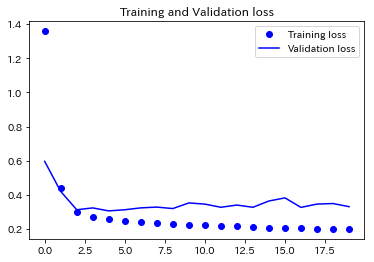

In [12]:
# 結果をプロット
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

- 検証データの損失値はベースラインを超えることはほぼできていない。  
- 機械学習全体の大きな制限として、学習アルゴリズムが特定の単純なモデルを探すようにハードコーディングされていない限り、パラメータの学習では、単純な問題に対する単純な解決策を見つけ出すのに失敗することがある。

### 6.3.5 最初のリカレントベースライン

- 最初の全結合アプローチはうまくいかなかったが、このアプローチでは、まず時系列データを平坦化することで、入力データから時間の概念を取り除いている。
- ここでは代わりに、データをそのままの状態で（シーケンスとして）調べてみることにする。最初のアプローチとは異なり、このモデルはデータ点の時間的な順序を利用するため、そうしたシーケンスデータに適合するはずである。
- ここでは、LSTM 層の代わりに、GRU(Gated Recurrent Unit) 層を使用する。GRU 層は、LSTM と同じ原理に基づいているが、少し効率化されているため、LSTM ほど実行コストが掛からない（ただし、LSTM ほど表現力がないことがある）。このような計算コストと表現力のトレードオフは、機械学習にはつきものである。

In [8]:
# GRU ベースのモデルの訓練と評価
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                                     steps_per_epoch=500,
                                                     epochs=20,
                                                     validation_data=val_gen,
                                                     validation_steps=val_steps)

/Users/takayukiishikawa/anaconda/envs/kaggle/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 304s 608ms/step - loss: 0.2997 - val_loss: 0.2727
Epoch 2/20
500/500 [==============================] - 308s 617ms/step - loss: 0.2871 - val_loss: 0.2677
Epoch 3/20
500/500 [==============================] - 307s 614ms/step - loss: 0.2804 - val_loss: 0.2673
Epoch 4/20
500/500 [==============================] - 307s 615ms/step - loss: 0.2759 - val_loss: 0.2679
Epoch 5/20
500/500 [==============================] - 307s 613ms/step - loss: 0.2700 - val_loss: 0.2676
Epoch 6/20
500/500 [==============================] - 296s 591ms/step - loss: 0.2651 - val_loss: 0.2659
Epoch 7/20
500/500 [==============================] - 302s 603ms/step - loss: 0.2612 - val_loss: 0.2757
Epoch 8/20
500/500 [==============================] - 300s 601ms/step - loss: 0.2551 - val_loss: 0.2689
Epoch 9/20
500/500 [==============================] - 300s 600ms/step - loss: 0.2516 - val_loss: 0.2765
Epoch 10/20
500/500 [==============================] - 303s 607m

In [9]:
# 結果をプロット
import matplotlib.pyplot as plt

def plotting_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

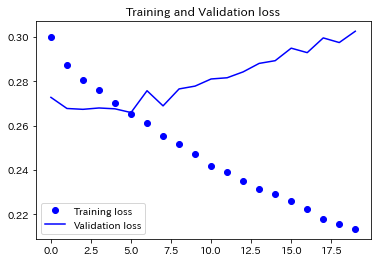

In [10]:
plotting_results(history)

- 結果をプロットすると、常識的なベースラインを大きくクリアしていることがわかる。
- これによって、機械学習の価値が実証されただけでなく、この種のタスクではシーケンスを平坦化する全結合ネットワークよりも RNN の方が圧倒的に優れていることも実証できている。

### 6.3.6 リカレントドロップアウトを使って過学習を抑制する

- 訓練データと検証データでの損失曲線から、このモデルが過学習に陥っていることは明らかである。この現象に対処するための従来の手法はドロップアウトである。ドロップアウトでは、層に供給される訓練データの偶発的な相関関係を破壊するために、層の入力ユニットをランダムに取り除く。しかし、RNN にドロップアウトを正しく適用するのは簡単ではない。
- RNN でドロップアウトを使用するための正しい方法は、時間刻みごとにドロップアウトマスクをランダムに変化させるのではなく、すべての時間刻みで同じドロップアウトマスクを適用することで、ドロップされるユニットのパターンを同じにすべきである。それだけでなく、GRU や LSTM といった層のリカレントゲートによって形成される表現を正則化するには、時間的に一定のドロップアウトマスクを層の内部のリカレント活性化に適用する必要がある。（リカレントドロップアウトマスク）
- すべての時間刻みで同じドロップアウトマスクを使用すると、ネットワークが時間の流れに沿って学習誤差を正しく伝播できるようになる。時間的にランダムなドロップアウトマスクは、この誤差信号を破壊してしまうため、学習プロセスにとって有害である。

<p>

- Keras のすべてのリカレント層には、ドロップアウト関連のパラメータが2つの定義される。1つは　dropout であり、その層の入力ユニットのドロップアウト率を　float で指定する。ドロップアウトとリカレントドロップアウトを GRU 層に追加して、過学習にどのような影響を与えるのか確認してみる。ドロップアウトを使ってネットワークを正則化する場合は、常に完全に収束するんにより時間がかかるようになる。このため、ネットワークを訓練する時のエポック数を2倍にする。

In [ ]:
# ドロップアウトで正則化した GRU ベースのモデルの訓練と評価
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                                     steps_per_epoch=500,
                                                     epochs=40,
                                                     validation_data=val_gen,
                                                     validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 352s 705ms/step - loss: 0.3410 - val_loss: 0.2786
Epoch 2/40
500/500 [==============================] - 349s 698ms/step - loss: 0.3155 - val_loss: 0.2788
Epoch 3/40
500/500 [==============================] - 349s 698ms/step - loss: 0.3078 - val_loss: 0.2706
Epoch 4/40
500/500 [==============================] - 350s 699ms/step - loss: 0.3045 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 350s 700ms/step - loss: 0.3018 - val_loss: 0.2713
Epoch 6/40
500/500 [==============================] - 350s 700ms/step - loss: 0.2979 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 349s 697ms/step - loss: 0.2975 - val_loss: 0.2711
Epoch 8/40
500/500 [==============================] - 349s 698ms/step - loss: 0.2961 - val_loss: 0.2713
Epoch 9/40
500/500 [==============================] - 348s 695ms/step - loss: 0.2946 - val_loss: 0.2667
Epoch 10/40
500/500 [==============================] - 349s 697m

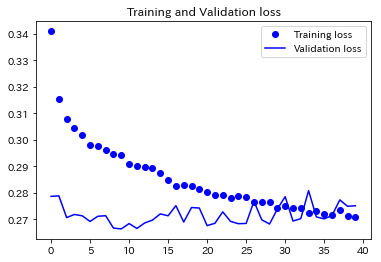

In [ ]:
plotting_results(history)

- 結果をプロットすると、最初の30エポックではもう過学習は発生していない。評価のスコアはこれまでよりも安定しているものの、ベストスコアは以前ほど低くない。

### 6.3.7 リカレント層のスタッキング

- 過学習に陥ることはなくなったが、性能にボトルネックがあるため、ネットワークのキャパシティを増やすことを検討すべきである。
- 一般に、ネットワークのキャパシティを増やすには、層のユニットの数を増やすか、層をさらに追加する。リカレント層のスタッキングは、より強力な RNN を構築するための典型的な方法である。Keras で複数のリカレント層をスタックとして積み上げるには、すべての中間層が（最後の時間刻みの出力ではなく）完全な出力シーケンス（3次元テンソル）を返す必要がある。これを可能にするには、*return_sequences = True* を指定する。

In [ ]:
# ドロップアウトで正則化された、スタッキング GRU モデルでの訓練と評価
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 716s 1s/step - loss: 0.3340 - val_loss: 0.2760
Epoch 2/40
500/500 [==============================] - 710s 1s/step - loss: 0.3133 - val_loss: 0.2752
Epoch 3/40
500/500 [==============================] - 715s 1s/step - loss: 0.3072 - val_loss: 0.2711
Epoch 4/40
500/500 [==============================] - 706s 1s/step - loss: 0.3015 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 709s 1s/step - loss: 0.2990 - val_loss: 0.2681
Epoch 6/40
500/500 [==============================] - 727s 1s/step - loss: 0.2954 - val_loss: 0.2660
Epoch 7/40
500/500 [==============================] - 734s 1s/step - loss: 0.2914 - val_loss: 0.2662
Epoch 8/40
500/500 [==============================] - 734s 1s/step - loss: 0.2880 - val_loss: 0.2811
Epoch 9/40
500/500 [==============================] - 736s 1s/step - loss: 0.2860 - val_loss: 0.2673
Epoch 10/40
500/500 [==============================] - 734s 1s/step - loss: 0.2839 - val_lo

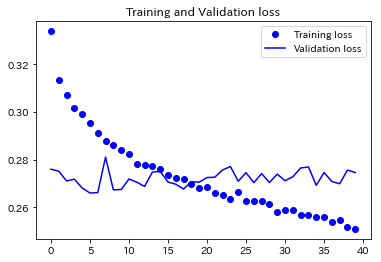

In [ ]:
plotting_results(history)

- 層を追加したことで結果は少し改善したが、それほど大きな改善ではない。このことから次の結論が導き出される。
    - まだ過学習はそれほどひどくないため、検証データでの損失値の改善を目指して、層のサイズを大きくしても安全である事が考えられる。ただし、その計算コストは無視できるほど小さなものではない。
    - 層を追加しても大幅な改善には至らなかったため、このポイントをネットワークキャパシティを増やすことによる収穫逓減と見なすこともできる。

---

### 6.3.8 双方向の RNN

- 双方向 RNN(bidirectional RNN)は一般的な RNN の一つであり、特定のタスクにおいて通常の RNN よりもよい性能が得られる。
- この RNN は自然言語処理(NLP)で効果があることが多く、よく使用される。

- RNN の特徴は、順序（時間）に依存することである。つまり、入力シーケンスの時間刻みを順番に処理する特徴が RNN にある。そして、それらの時間刻みをシャッフルしたり逆の順序にしたりすると、RNN がシーケンスから抽出する表現がすっかり変わってしまうことがある。
- 双方向 RNN は、RNN の順序に敏感な性質を利用する。双方向 RNN は、GRU や LSTM など、2つの標準的な RNN 層で構成される。これらの層はそれぞれ入力シーケンスを一方向で（時間の古い順及び新しい順に）処理し、続いてそれぞれの表現をマージする。シーケンスを双方向で処理することにより、双方向 RNN は一方向の RNN では見落とされるかもしれないパターンを補足することができる。

- 注目すべき点は、RNN 層がシーケンスを時間の順序で（時間刻みの古いものから順に）処理していることに論理的な必然性が合ったとは限らないことである。仮に、入力シーケンスを新しい時間刻みから順に処理していたとしても、それらの RNN の性能は十分なものだったかを検討するのが良い（6.3.2 の generator 関数の最後の行を ```yield sample[:, ::-1, :]. target``` に置き換える）。
- 結果としては、この GRU の性能はかなり悪く、常識的なベースラインすらクリアできていない。つまり、RNN を成功させるには、想定の通り、時間の順序で処理を行うことが重要である。GRU そうは一般に（遠い過去のことよりも）最近のことを覚えるほうが得意である。そして、当然ながら、説明変数として過去のデータ点よりも最近のデータ点のほうが重要である。
- しかし、個々で重要となるのは、このことが NLP といった他の問題にも当てはまるわけではないということである。直感的にわかるように、文章を解釈するときの単語の重要度は、通常は文章内での位置に依存しない。

In [ ]:
# 逆向きのシーケンスを用いた LSTM での訓練と評価
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                           loss='binary_crossentropy',
                           metrics=['acc'])
history = model.fit(x_train, y_train,
                                 epochs=10,
                                 batch_size=128,
                                 validation_split=0.2)

17465344/17464789 [==============================] - 8s 0us/step
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 263s 13ms/step - loss: 0.4837 - acc: 0.7704 - val_loss: 0.3907 - val_acc: 0.8390
Epoch 2/10
20000/20000 [==============================] - 226s 11ms/step - loss: 0.3088 - acc: 0.8821 - val_loss: 0.3099 - val_acc: 0.8818
Epoch 3/10
20000/20000 [==============================] - 221s 11ms/step - loss: 0.2575 - acc: 0.9054 - val_loss: 0.3105 - val_acc: 0.8798
Epoch 4/10
20000/20000 [==============================] - 220s 11ms/step - loss: 0.2138 - acc: 0.9243 - val_loss: 0.3901 - val_acc: 0.8704
Epoch 5/10
20000/20000 [==============================] - 236s 12ms/step - loss: 0.1911 - acc: 0.9345 - val_loss: 0.4753 - val_acc: 0.8124
Epoch 6/10
20000/20000 [==============================] - 220s 11ms/step - loss: 0.1738 - acc: 0.9396 - val_loss: 0.3672 - val_acc: 0.8770
Epoch 7/10
20000/20000 [============================

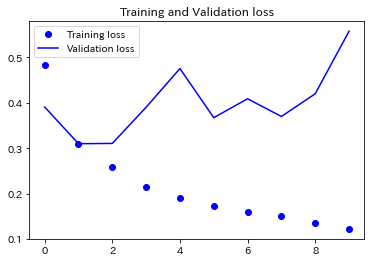

In [ ]:
plotting_results(history)

- この場合は、時間の順序で処理を行う LSTM にほぼ匹敵する性能が得られる。
    - 特筆すべきは、こうしたテキストのデータセットでは、時間の順序での処理と逆の順序での処理とで性能がほぼ同じであることである。
    - このことから、「単語の順序は言語を理解するにあたってたしかに重要であるものの、どちらの順序を使用するかはそれほど重要ではない」という仮説が裏付けられる。
    - 重要なのは、逆向きのシーケンスで訓練された RNN が、元のシーケンスで訓練された RNN とは異なる表現を学習することである。
    - アンサンブル(ensembling)の効果により、タスクにおける性能の向上に役立つ可能性がある。
    
- Keras で双方向 RNN をインスタンス化するには Bidirectional 層を使用する。
    - Bidirectional 層は、最初の引数としてリカレント層のインスタンスを受け取る。Bidirectional 層は、このリカレント層の2つ目のインスタンスを新たに作成する。そして、入力シーケンスを時間の順序で処理するために一方のインスタンスを使用し、入力シーケンスの逆順序で処理するためにもう一方のインスタンスを使用する。

In [ ]:
# LSTM ベースの双方向 RNN の訓練と評価（双方向 RNN を IMDb の感情タスクで試してみる）
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

- 検証データでの正解率は 89% 前後であり、前節で試した標準的な LSTM 層の性能を少し上回っている。
- また、双方向 RNN モデルは、Bidirectional 層のパラメータ数が通常の LSTM 層の2倍のため、過学習に陥りやすい。
    - そのため、このタスクでは双方向アプローチの性能は正則化によって大幅に改善される可能性がある。

### 6.3.9 さらに先に進むために

### 6.3.10 まとめ